In [3]:
%%shell
jupyter nbconvert --to html /content/MIE1620_Final_Project.ipynb


[NbConvertApp] Converting notebook /content/MIE1620_Final_Project.ipynb to html
[NbConvertApp] Writing 869509 bytes to /content/MIE1620_Final_Project.html


In [ ]:
# import library
import numpy as np
from scipy.optimize import linprog

## for visualization
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

## record time
import time

# 1. Pre-processing Functions

Original linear programming is shown as follows:

$$
\begin{align*}
\text{Min} \quad & 150x_1+230x_2+260x_3+238y_1+210y_2-170w_1-150w_2-36w_3-10w_4\\
\text{s.t.} \quad & x_1+x_2+x_3 \le 500\\
&x_1,x_2,x_3 \ge 0\\
&2.5x_1 + y_1-w_1 \ge 200\\
&3x_2+y_2 - w_2 \ge 240\\
&w_3+w_4 \le 20x_3\\
&w_3 \le 6000 \\
&w_{1,2,3,4}\ge 0, y_{1,2,3}\ge0
\end{align*}
$$

All pre-processing procedures are built upon the orignal LP.

In [ ]:
# original setups
c_original = np.array([150,230,260,238,210,-170,-150,-36,-10])
A_original = np.array([
[1,1,1,0,0,0,0,0,0],
[2.5,0,0,1,0,-1,0,0,0],
[0,3,0,0,1,0,-1,0,0],
[0,0,-20,0,0,0,0,1,1],
[0,0,0,0,0,0,0,1,0]
])
b_original = np.array([500,200,240,0,6000])

In [ ]:
def add_scenarios_pairs (c, A, b, yield_float, num_of_additions):
  """
  Expand constraints of a linear optimization problem under varying scenarios.

  Parameters:
  c (1-D array): Coefficient vector for the objective function. The first three elements are constants, while the remaining elements are subject to expansion.
  A (2-D array): Coefficient matrix for the constraints. This matrix will be expanded to accommodate additional scenarios.
  b (1-D array): Right-hand side vector of the constraints. It will be expanded similar to the 'c' vector.
  yield_float (float): A floating-point number representing a yield factor used in scenario generation. This factor influences how the scenarios are created.
  num_of_additions (int): The number of additional scenarios to be added and each addition adds 2 new symmetric scenarios. This number determines the extent of expansion for the 'A', 'c', and 'b' vectors.

  Returns:
  c_expanded (1-D array): The expanded coefficient vector for the objective function, accommodating additional scenarios.
  A_expanded (2-D array): The expanded coefficient matrix, incorporating additional rows for each scenario.
  b_expanded (1-D array): The expanded right-hand side vector, accommodating the expansion in 'A' and 'c'.

  Description:
  The function 'add_scenarios_pairs' expands the pairs of constraints of a linear optimization problem to account for different scenarios. It modifies and extends the 'c', 'A', and 'b' parameters of a linear program based on the specified number of additions (scenarios) and a yield factor.

  The expansion process involves:
  1. Keeping the first three elements of 'c' constant and tiling the remaining elements, adjusting them based on the number of additions.
  2. Keeping the first element of 'b' constant and tiling the remaining elements based on the number of additions.
  3. Expanding the ‘A’ matrix by adding zero columns for new variables and rows for each new scenario. The coefficients of average yield in each new scenario are calculated based on the yield float, and coefficients of new variables are updated according to the original ‘A’ matrix.

  The function returns the expanded vectors and matrix, which can then be used in a linear optimization solver to analyze different scenarios.
  """
  c_expanded = np.append(c[0:3], np.tile(c[3:]/ (num_of_additions*2+1), num_of_additions*2+1)) # add c for new scenarios
  b_expanded = np.concatenate((b[0:5], np.tile(b[1:5], num_of_additions * 2))) # add b for new scenarios

  # modify A
  # The number of original variables in A_original
  num_original_vars = A.shape[1]
  # Initialize the expanded matrix with the original matrix
  A_expanded = A.copy()
  # Calculate the number of new variables
  num_new_vars = 6 * 2 * num_of_additions
  # Add zero columns to the original block for the new variables
  A_expanded = np.hstack((A_expanded, np.zeros((A_expanded.shape[0], num_new_vars))))
  #
  scenarios = [np.array([1 - yield_float * i, 1 + yield_float * i]) for i in range(1, 1 + num_of_additions)]
  for add in range(num_of_additions):
    for i in range(2):
      # Create a new block for one of a scenario pair
      new_block = np.zeros((A.shape[0]-1, num_original_vars + num_new_vars))
      # Update new coefficient for x_1, x_2, x_3
      new_block[:, 0:3] = A[1:, 0:3] *  scenarios[add][i]
      # Insert coefficients for y and w
      new_block[:, 9 + 12 * add + i * 6: 9 + 12 * add + (i + 1) * 6] = A[1:,3:]
      # Append the new block to the expanded matrix
      A_expanded = np.vstack((A_expanded, new_block))

  return c_expanded, A_expanded, b_expanded

# generate the three scenario farming problem in the slides
c_new, A_new, b_new = add_scenarios_pairs (c_original, A_original,b_original, yield_float = 0.2, num_of_additions = 1)

In [ ]:
def standard_form (c, A, b, num_of_additions):
  """
  Transform a linear programming to standard form with additional scenarios (slacks).

  Parameters:
  c (1-D array): Coefficient vector for the objective function in the original problem.
  A (2-D array): Coefficient matrix for the constraints in the original problem.
  b (1-D array): Right-hand side vector of the constraints in the original problem.
  num_of_additions (int): The number of additional scenarios to be added, influencing the transformation process.

  Returns:
  c_std (1-D array): Transformed coefficient vector for the objective function in standard form, expanded to include additional variables.
  A_std (2-D array): Transformed and expanded coefficient matrix in standard form, accommodating the additional scenarios and slack variables.
  b_std (1-D array): Remain Unchanged

  Description:
  The 'standard_form' function converts the constraints of a linear optimization problem into a standard form suitable for solving, especially under the context of multiple scenarios. The transformation process involves expanding the 'c', 'A', and 'b' parameters of the linear program to incorporate additional slacks.

  The expansion process includes:
  1. Expanding 'c' by adding zeros to account for slack variables.
  2. Copying 'b'
  3. Creating a slack variable coefficient matrix ('A_slack') based on the original and additional scenarios, and concatenating it with 'A' to form 'A_std'.

  The function returns the transformed vectors and matrix ('c_std', 'A_std', 'b_std'), which represent the problem in standard form, ready for solving with linear optimization techniques.
  """
  # modify C
  c_std = np.concatenate((c, np.zeros(A.shape[0])))

  # modify B (remain unchanged)
  b_std = b.copy()

  # modify A
  slack_coefficients_original = [1, -1, -1, 1, 1]
  slack_coefficients_addition = np.tile(slack_coefficients_original[1:], num_of_additions * 2)
  slack_coefficients_total = np.concatenate((slack_coefficients_original, slack_coefficients_addition))
  A_slack = np.diag(slack_coefficients_total)
  A_std = np.concatenate((A, A_slack),axis = 1)

  return c_std, A_std, b_std


# transform the three scenario farming problem in the slides into standard form
c_sd, A_sd, b_sd = standard_form(c_new, A_new, b_new, 1)

# 2. Simplex Method

In [ ]:
def simplex_method(c, A, b, B_bar_=None, N_bar_=None, xB_ = None, xN_ = None, B_= None, N_=None, phase = None):
    """
    Solve a linear programming (LP) problem using the Simplex method.

    Parameters:
    c (1-D array): Coefficient vector of the objective function to be minimized.
    A (2-D array): Coefficient matrix of the constraints in canonical form.
    b (1-D array): Right-hand side vector of the constraints in canonical form.
    B_bar_ (1-D array, optional): Initial basis variable indices. Defaults to the last m columns of A if None.
    N_bar_ (1-D array, optional): Initial non-basis variable indices. Defaults to the first n-m columns of A if None.
    xB_ (1-D array, optional): Initial basic variable values. Defaults to b if None.
    xN_ (1-D array, optional): Initial non-basic variable values. Defaults to zeros if None.
    B_ (2-D array, optional): Initial basis matrix. Defaults to the last m columns of A if None.
    N_ (2-D array, optional): Initial non-basis matrix. Defaults to the first n-m columns of A if None.
    phase (string, optional): The current phase of the Simplex algorithm. Used for printing messages.

    Returns:
    xB (1-D array): Basic variable values at the optimal solution.
    xN (1-D array): Non-basic variable values at the optimal solution.
    B_bar (1-D array): Basis variable indices at the optimal solution.
    N_bar (1-D array): Non-basis variable indices at the optimal solution.
    B (2-D array): Basis matrix at the optimal solution.
    N (2-D array): Non-basis matrix at the optimal solution.
    optimal (float): Optimal objective value.

    Description:
    The `simplex_method` function implements the Simplex algorithm for solving linear programming problems in canonical form. The function iteratively updates the solution by performing pivoting operations. The method involves checking for optimality, selecting entering and leaving variables, generating descent direction, unboundedness check, and updating the basis and solution.

    The algorithm proceeds through the following steps:
    1. Initialization: Set up initial basis and non-basis variables and matrices.
    2. Optimality Check: Verify if the current solution is optimal.
    3. Pivot Operation: Select an entering variable and a leaving variable, and perform a pivot to update the basis.
    4. Solution Update: Update the values of basic and non-basic variables, and the basis and non-basis matrices.
    5. Iteration: Repeat the process until an optimal solution is found or the problem is deemed unbounded.

    The function terminates when an optimal solution is found, the problem is identified as unbounded, or the maximum number of iterations is reached. Informative messages are printed, indicating the current status of the algorithm.
    """
    m, n = A.shape

    if B_bar_ is None and N_bar_ is None:
        B_bar = np.arange(n-m,n)  # Initial basis variable indices
        N_bar = np.arange(n-m)  # Initial non-basis variable indices
          # Initial basis matrix
        cB = np.ones(m)  # Initial basis coefficients
        cN = np.zeros(n-m)    # Initial non-basis coefficients
          # Initial non-basis matrix

    else:
        B_bar = B_bar_
        N_bar= N_bar_
        cB = c[B_bar]
        cN = c[N_bar]


    if xB_ is None and xN_ is None:
        xB = b.copy() + 1e-24     # Initial basic variables
        xN = np.zeros(n-m)  # Initial non-basic variables

    else:
        xB = xB_ + 1e-24    # Initial basic variables
        xN = xN_

    if B_ is None and N_ is None:
        B = A[:, -m:].astype(float)
        N = A[:, :-m]

    else:
        B = B_   # Initial basic variables
        N = N_


    #construct original x
    x = np.concatenate((xB, xN))

    #limit the iteration in case the calculator break down
    max_iterations = 10000
    iteration = 0

    #iteration part
    while iteration < max_iterations:
        # Step 1: Optimality Check
        B_inv_N = np.linalg.solve(B, N)
        r_N = cN - cB.T @ B_inv_N

        #output for result if no direction has better solution
        if np.all(r_N >= 0):
            x = np.concatenate((xB, xN))
            x = x[np.argsort(np.concatenate((B_bar, N_bar)))]
            optimal = c @ x

            print(f"Optimal solution found for {phase}.")
            return xB, xN,B_bar,N_bar,B,N, optimal

        # Select entering variable
        q = np.argmin(r_N)

        # Step 2: Descent Direction Generation
        d = np.linalg.solve(B, -N[:, q])

        # Step 3: Unbounded Check
        if all(d >= 0):
            print(f"The {phase} problem is unbounded.")
            return None, None, None, None, None, None, None

        # Step 4: Step Length Generation (Minimum Ratio Test)
        mask = d < 0
        result_array = np.zeros_like(d)
        result_array[mask] = xB[mask] / d[:m][mask]
        result_array[mask]
        alpha=min(-result_array[mask])


        # Step 5: Improved Adjacent Basic Feasible Solution
        xB = xB + alpha * d
        xN[q] = alpha

        # Basis Update
        leaving_index = np.argmin(xB)

        #update B and N by exchanging the corresponding value with entering/leaving index
        temp = B[:, leaving_index].copy()
        B[:, leaving_index] = N[:, q]
        N[:, q] = temp

        #update cB and cN by exchanging the corresponding value with entering/leaving index
        temp2 = cB[leaving_index]
        cB[leaving_index] = cN[q]
        cN[q] = temp2

        #update xB and xN by exchanging the corresponding value with entering/leaving index
        temp3 = xB[leaving_index]
        xB[leaving_index] = xN[q]
        xN[q] = temp3

        #update B_bar and N_bar by exchanging the corresponding value with entering/leaving index
        temp4 = B_bar[leaving_index]
        B_bar[leaving_index] = N_bar[q]
        N_bar[q] = temp4


        iteration += 1


    print("Maximum number of iterations reached.")
    return None, None, None, None, None, None, None

In [ ]:
def two_phase_simplex_method(c, A, b):
    """
    Solve a linear programming problem using the two-phase simplex method.

    Parameters:
    c (1-D array): Coefficient vector of the objective function to be minimized.
    A (2-D array): Coefficient matrix of the constraints in canonical form.
    b (1-D array): Right-hand side vector of the constraints in canonical form.

    Returns:
    optimal_x (1-D array): Optimal solution of the original linear programming problem.
    optimal_obj (float): Optimal objective value of the original linear programming problem.

    Description:
    The `two_phase_simplex_method` function implements the two-phase simplex algorithm to solve linear programming problems. This method is particularly useful when the initial basic feasible solution is not readily available.

    The algorithm involves two main phases:
    1. Phase I:
      - Constructs and solves an auxiliary linear program with artificial variables to find a basic feasible solution.
      - If artificial variables remain in the basis with non-zero values at the end of Phase I, the original problem is infeasible.
    2. Phase II:
      - Uses the basic feasible solution obtained from Phase I to solve the original problem.
      - The original objective function coefficients and constraints are used.

    The function performs the following steps:
    - Initialize and augment the problem with artificial variables.
    - Solve the auxiliary problem in Phase I using the simplex method.
    - Check for infeasibility based on the solution from Phase I.
    - Remove artificial variables and solve the original problem in Phase II using the simplex method.

    If the problem is found to be infeasible in Phase I, the function returns None. Otherwise, it proceeds to Phase II and returns the optimal solution and the optimal objective value for the original problem.

    Note:
    The function relies on the `simplex_method` function for solving linear programming problems in both phases.
    """

    m, n = A.shape
    # Create the artificial variables matrix
    A_artificial = np.eye(m)


    # Concatenate the artificial variables to the constraint matrix
    A_extended = np.hstack((A, A_artificial))
    A_org= A.copy()

    # Formulate the Phase I problem
    c_phase1 = np.zeros(n + m)  # Coefficients for the artificial variables
    c_phase1[np.arange(n, n + m)] = 1  # Minimize the sum of artificial variables

    # Solve the phase oneusing the simplex method
    xB_phase1, xN_phase1,B_bar_phase1, N_bar_phase1, B_phase1, N_phase1, _ = simplex_method(c_phase1, A_extended, b, B_bar_=None, N_bar_=None, phase = 'Phase 1')

    if xB_phase1 is None:
        print("Phase I: The problem is infeasible.")
        return None

    if any(xB_phase1[n:] != 0):
        print("Phase I: The problem has artificial variables in the basis after Phase I.")
        return None

    #remove artifical var from N xN
    N_bar_phase2 = N_bar_phase1[np.argsort(N_bar_phase1)[:-m]]
    xN_phase2=xN_phase1[np.argsort(N_bar_phase1)[:-m]]
    N_phase2=N_phase1[:, np.argsort(N_bar_phase1)[:-m]]
    #print("output",c, A, b,B_bar_phase1, N_bar_phase2,xB_phase1, xN_phase2, B_phase1,N_phase2)

    #solve phase two problem and get the output for phase two simplex method
    xB, xN,B_bar,N_bar,B,N, optimal_obj = simplex_method(c, A, b,B_bar_phase1, N_bar_phase2, xB_phase1, xN_phase2, B_phase1,N_phase2, phase = 'Phase 2')

    #output optimal value
    A_bar = np.hstack((B_bar, N_bar))
    x_optimal = np.hstack((xB, xN))

    # Pairing elements of A_bar with their corresponding elements in x
    paired = zip(A_bar, x_optimal)

    # Sorting the pairs according to the values in A_bar
    sorted_pairs = sorted(paired)

    # Extracting the sorted elements of x
    optimal_x = [value for _, value in sorted_pairs]

    # Also, sorting A_bar for consistency
    sorted_A_bar = sorted(A_bar)

    return optimal_x, optimal_obj


In [ ]:
# find optimal solution with simplex method for 3 scenarios
## record time of running function
start_time_simplex = time.perf_counter()
optimal_x_simplex, optimal_z_simplex = two_phase_simplex_method(c_sd, A_sd, b_sd)
end_time_simplex  = time.perf_counter()
elapsed_time_simplex = end_time_simplex - start_time_simplex

Optimal solution found for Phase 1.
Optimal solution found for Phase 2.


# 3. Primal Affine Scaling

In [ ]:
def primal_affine_scaling (c, A_sd, b_sd, epsilon, a_scale, x0, max_iteration, phase):
  """
  Solve a linear programming (LP) problem using the primal affine scaling algorithm.

  Parameters:
  c (1-D array): Coefficient vector of the objective function in the LP problem.
  A_sd (2-D array): The constraint matrix (LHS) in standard form for the LP problem.
  b_sd (1-D array): The constraint vector (RHS) in standard form for the LP problem.
  epsilon (float): Decision duality gap threshold. The iteration stops when the duality gap is smaller than this value.
  a_scale (float): Step length for each iteration in y-space, a real number between 0 and 1.
  x0 (1-D array): Initial interior feasible solution for starting the algorithm.
  max_iteration (int): Maximum number of iterations after which the algorithm will stop.
  phase (string): Either "Phase One" or "Phase Two", indicating the phase of the problem the algorithm is currently solving.

  Returns:
  x (array): The best interior feasible point found that minimizes the objective of the LP problem using this algorithm.
  current_obj (float): The best objective value of the LP problem obtained with this algorithm.

  Description:
  The `primal_affine_scaling` function implements the primal affine scaling algorithm to solve linear programming problems. The algorithm iteratively updates the solution based on the provided parameters and stops when either the optimal solution is found, the LP is deemed unbounded, any feasible solution is optimal, a feasible solution cannot be maintained, or the maximum number of iterations is reached.

  The algorithm follows these steps:
  1. Initialization: Start with the initial feasible solution 'x0'.
  2. Stopping Rule: Check if the current solution is feasible and if the duality gap is within the specified 'epsilon'.
  3. Direction of Movement: Determine the direction in which to move from the current point.
  4. Update Solution: Calculate the step length using 'a_scale' and update the solution 'x'.

  The function prints informative messages regarding the state of the algorithm, such as achieving optimality, unboundedness, feasibility issues, or reaching the maximum number of iterations. The final return values are the best feasible point and the corresponding objective value found within the allowed iterations or constraints.
  """
  i=0
  # Step one: initiation
  x = x0
  current_obj = c.T @ x
  for i in range(max_iteration):
    # Step two: Stopping rule
    if (x>=0).all() and np.allclose(A_sd @ x, b_sd):
      X = np.diag(x)
      w = np.linalg.solve(A_sd @ np.square(X) @ A_sd.T, A_sd @ np.square(X) @ c)
      r = c - A_sd.T @ w
      duality_gap = x @ r
      if (r >= 0).all() and duality_gap <= epsilon:
        print(f"Optimal solution is found for {phase}.")
        return x, current_obj
      # Step three:
      d_y = -X@r + 1e-24 ## add a sufficiently small number to avoid dividing zeros to reduce computing time
      if (d_y > 0).all():# Check whether LP is unbounded
        print(f"{phase} LP is unbounded")
        return None, None
      if (d_y == 0).all(): # Check whether any feasible solution is optimal
        print(f"Every feasible solution in {phase} is optimal.")
        return x, current_obj
      # Step four: Compute Step-length and move toward a feasible and good direction
      else:
        a = np.min(a_scale / (-d_y [d_y < 0]))
        d_x = X @ d_y
        x_previous = x.copy()
        x = x+np.dot(a, d_x)
        current_obj = c.T @ x
    else:
      print(f"The current solution for {phase} is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.")
      return x_previous, c.T @ x_previous
  print(f"Maximum number of iterations reached. Here is the current x and objective for {phase}.")
  return x, current_obj

In [ ]:
def two_phase_primal_affine_scaling (c_sd, A_sd, b_sd, epsilon, a_scale, max_iteration):
  """
  Solve a linear programming (LP) problem using the two-phase primal affine scaling algorithm.

  Parameters:
  c_sd (1-D array): Coefficient vector of the objective function in the LP problem.
  A_sd (2-D array): The constraint matrix (LHS) in standard form for the LP problem.
  b_sd (1-D array): The constraint vector (RHS) in standard form for the LP problem.
  epsilon (float): Decision duality gap threshold. The iteration stops when the duality gap is smaller than this value.
  a_scale (float): Step length for each iteration, a real number between 0 and 1.
  max_iteration (int): Maximum number of iterations after which the algorithm will stop.

  Returns:
  optimal_x (1-D array): The optimal solution (a point extraordinarily close to or at the optimal BFS) of the LP.
  optimal_obj (float): The optimal objective value of the LP.

  Description:
  The `two_phase_primal_affine_scaling` function implements a two-phase approach using the primal affine scaling algorithm to solve linear programming problems. The first phase aims to find a feasible starting point for the LP problem, and the second phase focuses on optimizing the objective function starting from this feasible point.

  Phase One:
  1. Initialize: Start with a randomly generated feasible solution.
  2. Construct a new LP: Form an artificial LP problem by adding a new variable and adjusting the 'A' matrix and 'c' vector accordingly.
  3. Solve Phase One: Use the primal affine scaling algorithm to solve this artificial problem.

  Phase Two:
  1. Feasibility Check: Verify if a feasible solution was found in Phase One. If not, the problem is deemed infeasible.
  2. Initialize with Phase One Solution: Use the solution from Phase One as the starting point for Phase Two.
  3. Solve Phase Two: Use the primal affine scaling algorithm to find the optimal solution to the original problem.

  The function returns the optimal solution and the corresponding optimal objective value if the problem is feasible and bounded. Otherwise, it returns None, indicating infeasibility or unboundedness of the problem. Additionally, the optimal solution is rounded to the nearest integer to potentially reach a vertex of the feasible region.
  """
  # phase one
  np.random.seed(0) # for reproducibility

  ## randomly pick a x>0 and calculate v=b-Ax
  x_0 = np.random.rand(c_sd.shape[0])*20
  v = (b_sd - A_sd @ x_0).reshape(A_sd.shape[0],1)

  ## construct a new phase one LP
  A_artificial = np.concatenate((A_sd, v), axis=1)
  c_artificial = np.hstack((np.zeros(A_sd.shape[1]), 1))
  x_0 = np.hstack((x_0,1))

  ## solve the phase one LP with primal-affine scaling
  x_phase_1, _ = primal_affine_scaling(c_artificial, A_artificial, b_sd, epsilon, a_scale, x_0, max_iteration, phase = 'Phase One')

  ## check whether the phase one problem is feasible
  if x_phase_1 is None:
    print("Phase 1 is infeasible")
    return None, None
  ## Take the optimal solution from phase 1 to be the initial feasible soltuion to start phase two
  x0 = x_phase_1[:len(c_sd)]
  # phase two
  optimal_x, optimal_obj = primal_affine_scaling (c_sd, A_sd, b_sd, epsilon, a_scale, x0, max_iteration, phase = 'Phase Two')

  ## check whether the LP is unbounded
  if optimal_x is None:
    return None, None

  ## round the result to jump onto a vertex
  optimal_x = np.round(optimal_x,0).astype(int)
  optimal_obj = c_sd.T @ optimal_x
  print('The optimal solution for the LP is found.')
  return optimal_x, optimal_obj

In [ ]:
# find optimal solution with primal affine scaling method for 3 scenarios
start_time_pas = time.perf_counter()
optimal_x_interior, optimal_z_interior = two_phase_primal_affine_scaling (c_sd, A_sd, b_sd, 1e-24, 0.1,100000)
end_time_pas  = time.perf_counter()
elapsed_time_pas = end_time_pas - start_time_pas

The current solution for Phase One is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The current solution for Phase Two is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The optimal solution for the LP is found.


# 4. LinProg

In [ ]:
# construct LP result through linprog
start_time_linprog = time.perf_counter()
res = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex')
optimal_x_linprog = res.x
optimal_z_linprog = res.fun
end_time_linprog  = time.perf_counter()
elapsed_time_linprog = end_time_linprog - start_time_linprog

<ipython-input-11-a19fd2e12582>:3: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  res = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex')


# 5. Results

## 5.1 Test results from three methods for three scenarios when yield -20% and +20%

In [ ]:
print("Simplex Method")
print("Optimal Solution:",np.round(optimal_x_simplex))
print("Optimal Objective:",optimal_z_simplex)
print("Running Time:", elapsed_time_simplex)

Simplex Method
Optimal Solution: [ 170.   80.  250.    0.    0.  225.    0. 5000.    0.   -0.   48.  140.
    0. 4000.    0.    0.    0.  310.   48. 6000.    0.    0.    0.    0.
    0. 1000.    0.    0.    0. 2000.    0.    0.    0.    0.]
Optimal Objective: -108390.0
Running Time: 0.011847184999993488


In [ ]:
print("Primal Affine Scaling Method")
print("Optimal Solution:",optimal_x_interior)
print("Optimal Objective:",optimal_z_interior)
print("Running Time:", elapsed_time_pas)

Primal Affine Scaling Method
Optimal Solution: [ 170   80  250    0    0  224    1 5002    0    0   47  139    0 4002
    0    0    0  309   49 6000    3    0    0    0    0  998    0    0
    0 1998    0    0    1    0]
Optimal Objective: -108447.99999999997
Running Time: 0.2750808989999882


In [ ]:
print("Linprog Library")
print("Optimal Solution:",optimal_x_linprog)
print("Optimal Objective:",optimal_z_linprog)
print("Running Time:", elapsed_time_linprog)

Linprog Library
Optimal Solution: [ 170.   80.  250.    0.    0.  225.    0. 5000.    0.    0.   48.  140.
    0. 4000.    0.    0.    0.  310.   48. 6000.    0.    0.    0.    0.
    0. 1000.    0.    0.    0. 2000.    0.    0.    0.    0.]
Optimal Objective: -108390.0
Running Time: 0.08063719500000843


# 5.2 Compare the performance of three methods by adding more scenarios

In [ ]:
mse_list_simplex = []
z_from_simplex = []
z_from_lingprog = []
time_simplex = []

for num_of_add in range(1, 15): # compute optimal solution and objective for each addition of scenarios
  c_new, A_new, b_new = add_scenarios_pairs (c_original, A_original,b_original, yield_float = 0.1, num_of_additions = num_of_add)
  c_sd, A_sd, b_sd = standard_form(c_new, A_new, b_new, num_of_additions = num_of_add)
  print(f"Iteration {num_of_add}")
  try:

    start_time_simplex = time.perf_counter() # record time for simplex
    optimal_x_simplex, optimal_z_simplex = two_phase_simplex_method(c_sd, A_sd, b_sd) # compute results using simplex method
    end_time_simplex  = time.perf_counter()
    elapsed_time_simplex =  end_time_simplex - start_time_simplex
    time_simplex.append(elapsed_time_simplex) # store running time of simplex for each iteration
    z_from_simplex.append(optimal_z_simplex) # store optimal objective from simplex method for each addition

    result_linprog = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex') # using linprog
    z_linprog = result_linprog.fun
    x_linprog = result_linprog.x
    z_from_lingprog.append(z_linprog) # store optimal objective from linprog for each addition

    mse_list_simplex.append(np.mean((x_linprog - optimal_x_simplex) ** 2)) # store mse of optimal x for each iteration

  except Exception: # stop when our simplex method reachs the capacity
    print("The simplex method cannot handle any more scenarios.")
    print(f"The Manual Simplex Method Can only handle at most {(num_of_add - 1) * 2 + 1} scenarios")
    break

Iteration 1
Optimal solution found for Phase 1.
Optimal solution found for Phase 2.
Iteration 2
Optimal solution found for Phase 1.
Optimal solution found for Phase 2.


<ipython-input-24-a6458480593e>:19: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  result_linprog = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex') # using linprog


Iteration 3
Optimal solution found for Phase 1.
Optimal solution found for Phase 2.
Iteration 4
The simplex method cannot handle any more scenarios.
The Manual Simplex Method Can only handle at most 7 scenarios


In [ ]:
mse_list_interior = []
z_from_interior = []
z_from_linprog = []
time_pas = []
time_linprog = []

for num_of_add in range(1, 30):
  c_new, A_new, b_new = add_scenarios_pairs (c_original, A_original,b_original, yield_float = 0.1, num_of_additions = num_of_add)
  c_sd, A_sd, b_sd = standard_form(c_new, A_new, b_new, num_of_additions = num_of_add)
  print(f"Iteration {num_of_add}")
  try:

    start_time_pas = time.perf_counter() # record time for primal affine scaling
    optimal_x_interior, optimal_z_interior = two_phase_primal_affine_scaling (c_sd, A_sd, b_sd, 1e-24, 0.1,100000) # compute results using primal affine scaling
    end_time_pas  = time.perf_counter()
    elapsed_time_pas = end_time_pas - start_time_pas
    time_pas.append(elapsed_time_pas) # store running time of primal affine scaling for each iteration
    z_from_interior.append(optimal_z_interior) # store optimal objective from primal affine scaling for each addition

    start_time_linprog = time.perf_counter() # record time for linprog
    result_linprog = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex') # using linprog
    end_time_linprog  = time.perf_counter()
    elapsed_time_linprog = end_time_linprog - start_time_linprog
    time_linprog.append(elapsed_time_linprog) # store running time of linprog for each iteration
    z_linprog = result_linprog.fun
    x_linprog = result_linprog.x
    z_from_linprog.append(z_linprog) # store optimal objective from linprog for each addition

    mse_list_interior.append(np.mean((x_linprog - optimal_x_interior) ** 2)) # store mse of optimal x for each iteration

  except Exception: # stop when our primal affine scaling reachs the capacity
    print("The primal affine scaling cannot handle any more scenarios.")
    print(f"The Manual Primal Affine Scaling Method Can only handle at most {(num_of_add - 1) * 2 + 1} scenarios")
    break

Iteration 1
The current solution for Phase One is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The current solution for Phase Two is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The optimal solution for the LP is found.
Iteration 2


<ipython-input-16-2e4da790dcd7>:21: DeprecationWarning: `method='simplex'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  result_linprog = linprog(c_sd,A_eq=A_sd, b_eq=b_sd, bounds=(0,None), method='simplex') # using linprog


The current solution for Phase One is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The current solution for Phase Two is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The optimal solution for the LP is found.
Iteration 3
The current solution for Phase One is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The current solution for Phase Two is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The optimal solution for the LP is found.
Iteration 4
The current solution for Phase One is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The current solution for Phase Two is no longer feasible, so the solution in the previous iteration is the best feasible solution we can reach.
The optimal solution for the

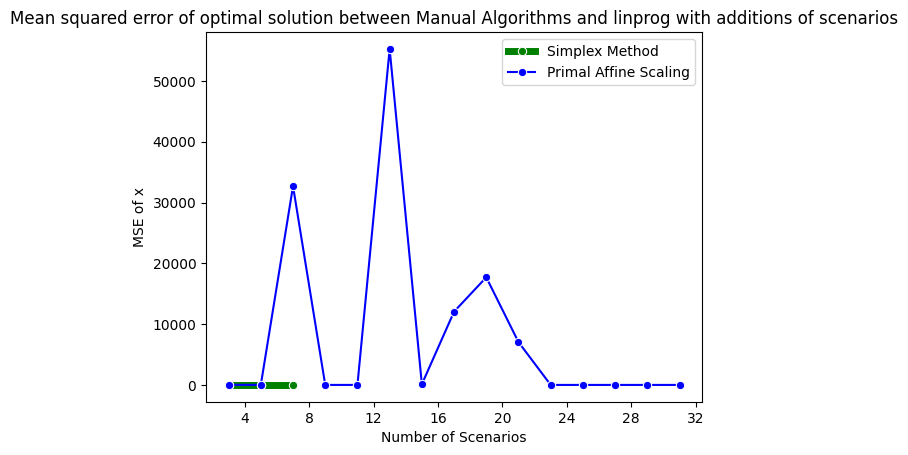

In [ ]:
# plot
x_labels_interior = list(range(3, len(mse_list_interior)*2 +2, 2))
x_labels_simplex = x_labels_interior[:len(mse_list_simplex)]

# Creating a line plot
sns.lineplot(x=x_labels_simplex, y=mse_list_simplex, marker='o', color='green', label = 'Simplex Method', linewidth=5)
sns.lineplot(x=x_labels_interior, y=mse_list_interior, marker='o', color='blue', label = 'Primal Affine Scaling')

# Adding labels and title
plt.xlabel('Number of Scenarios')
plt.ylabel('MSE of x')
plt.title('Mean squared error of optimal solution between Manual Algorithms and linprog with additions of scenarios')

# Ensuring y-axis labels are integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

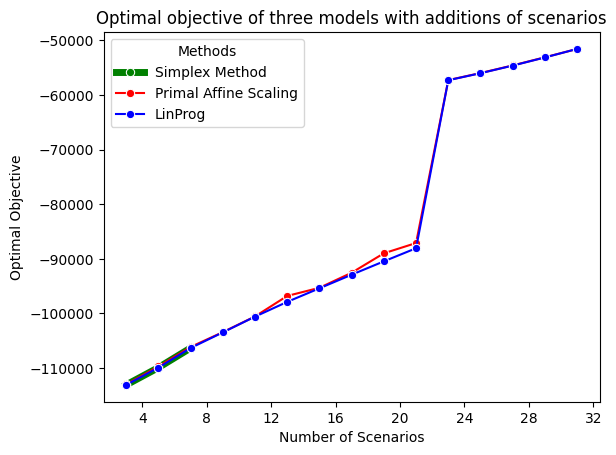

In [ ]:
# plot
sns.lineplot(x=x_labels_simplex, y=z_from_simplex, marker='o', color='green', label='Simplex Method', linewidth=5)
sns.lineplot(x=x_labels_interior, y=z_from_interior, marker='o', color='red', label='Primal Affine Scaling')
sns.lineplot(x=x_labels_interior, y=z_from_linprog, marker='o', color='blue', label='LinProg')

# Adding labels and title
plt.xlabel('Number of Scenarios')
plt.ylabel('Optimal Objective')
plt.title('Optimal objective of three models with additions of scenarios')
plt.legend(title='Methods', loc='upper left', frameon=True)
# Ensuring y-axis labels are integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()

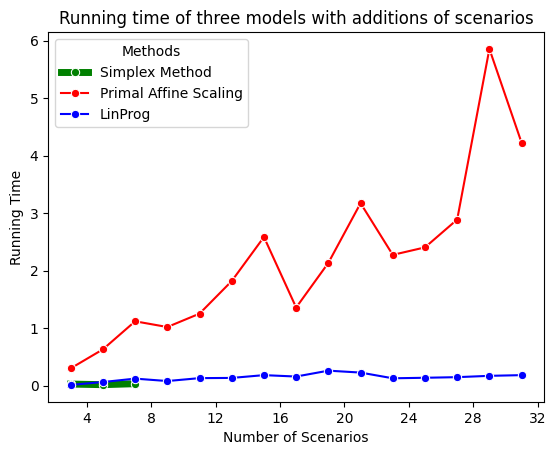

In [ ]:
# plot
sns.lineplot(x=x_labels_simplex, y=time_simplex, marker='o', color='green', label='Simplex Method', linewidth=5)
sns.lineplot(x=x_labels_interior, y=time_pas, marker='o', color='red', label='Primal Affine Scaling')
sns.lineplot(x=x_labels_interior, y=time_linprog, marker='o', color='blue', label='LinProg')

# Adding labels and title
plt.xlabel('Number of Scenarios')
plt.ylabel('Running Time')
plt.title('Running time of three models with additions of scenarios')
plt.legend(title='Methods', loc='upper left', frameon=True)
# Ensuring y-axis labels are integers
plt.gca().xaxis.set_major_locator(ticker.MaxNLocator(integer=True))

# Show the plot
plt.show()